In [1]:
import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit
import cProfile

In [371]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for n in range(5):
            for k in range(50):
                s ='x'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)               
                
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    tdd_new=renormalize(tdd_new)
    return tdd_new

In [404]:
def eliminate_global_map(tdd):
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.father.level>-1:
        the_map=the_map.father
        
    q = int(tdd.key_2_index[the_map.level][1:])
    if tdd.key_2_index[the_map.level][0]=='x':
        if the_map.rotate>0:
            cir_head.p(np.pi/4*(8-the_map.rotate),q)
        if the_map.x==1:
            cir_head.x(q)
    else:
        if the_map.x==1:
            cir_end.x(q)
        if the_map.rotate>0:
            cir_end.p(np.pi/4*(8-the_map.rotate),q)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new2,cir_head2,cir_end2 = eliminate_global_map(tdd_new)
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def eliminate_control(tdd,x,the_map):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    q_c = int(tdd.key_2_index[x][1:])
    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
            continue
        q = int(tdd.key_2_index[the_map.level][1:])
#         print(q_c,q)

        if tdd.key_2_index[the_map.level][0]=='x':
            if the_map.x==1:
                cir_head.cx(q_c,q)
            if the_map.rotate>0:
                cir_head.cp(np.pi/4*(8-the_map.rotate),q_c,q)
        else:
            if the_map.x==1:
                cir_end.cx(q_c,q)
            if the_map.rotate>0:
                cir_end.cp(np.pi/4*(8-the_map.rotate),q_c,q)
        the_map=the_map.father
        
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new = renormalize(tdd_new)
    return tdd_new,cir_head,cir_end


def eliminate_control2(tdd,mode='x'):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if mode=='x':
        x=tdd.node.key
        the_map = tdd.node.out_maps[1]
    else:
        x=tdd.node.successor[0].key
        the_map = tdd.node.successor[0].out_maps[1]
    
    q_c = int(tdd.key_2_index[x][1:])

    flag = False
    if the_map.level==-1:
        return tdd.self_copy(),cir_head,cir_end


    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
        else:
            flag = True
            temp_map=the_map
            the_map=the_map.father

    if flag == False:
        return tdd.self_copy(),cir_head,cir_end
    
        
    q = int(tdd.key_2_index[temp_map.level][1:])

    if tdd.key_2_index[temp_map.level][0]=='x':
        if temp_map.x==1:
            cir_head.cx(q_c,q)
        if temp_map.rotate>0:
            cir_head.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
    else:
        if temp_map.x==1:
            cir_end.cx(q_c,q)
        if temp_map.rotate>0:
            cir_end.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new2,cir_head2,cir_end2 = eliminate_control2(tdd_new,mode)
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def reduced_two_qubit(tdd):
    # if tdd.map.level!=-1:
    #     return False

    the_map = tdd.node.successor[0].out_maps[1]
    if the_map.level!=1:
        return True
    
    the_map = tdd.node.out_maps[1]
    if the_map.level==0:
        return False
    while the_map.level>0:
        the_map = the_map.father
    if the_map.level==0:
        return False
            
    return True


def reduce_hadamard2(tdd,n,qc,qt,case=0):
    # n = 2
    # cir_head = QuantumCircuit(n)
    # cir_end = QuantumCircuit(n)
    

    if case<2:
        k=case
        a=bin(k+1)[2:]
        a='0'*(2-len(a))+a
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
        tdd_temp=tdd.self_copy()
        if a[1]=='0':
            cir_head.cz(qc,qt)
            cir_head.h(qc)
            cir_head.h(qt)
            cir_head.cz(qc,qt)
        if a[0]=='0':
            cir_end.cz(qc,qt)
            cir_end.h(qc)
            cir_end.h(qt)
            cir_end.cz(qc,qt)
        
        tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
        return tdd_new,cir_head,cir_end
    else:
        k=case-2
        a=bin(k+1)[2:]
        a='0'*(2-len(a))+a
        cir_head = QuantumCircuit(n)
        cir_end = QuantumCircuit(n)
        tdd_temp=tdd.self_copy()
        if a[1]=='0':
            cir_head.cz(qc,qt)
            cir_head.h(qc)
            cir_head.h(qt)
            cir_head.cz(qc,qt)
            cir_head.h(qc)
            cir_head.h(qt)
            cir_head.cz(qc,qt)            
        if a[0]=='0':
            cir_end.cz(qc,qt)
            cir_end.h(qc)
            cir_end.h(qt)
            cir_end.cz(qc,qt)
            cir_end.h(qc)
            cir_end.h(qt)
            cir_end.cz(qc,qt)            
        
        tdd_new = update_tdd(tdd_temp,cir_head,cir_end)
        return tdd_new,cir_head,cir_end  


def eliminate_top_level(tdd):
    
    the_map1 = tdd.node.out_maps[1]
    tdd_new,cir_head,cir_end = eliminate_control(tdd,tdd.node.key,the_map1)
    
    the_map2 = tdd.node.successor[0].out_maps[1]
    tdd_new2,cir_head2,cir_end2 = eliminate_control(tdd_new,tdd.node.successor[0].key,the_map2)
    
    
#     if tdd.node.successor[0]!=tdd.node.successor[1]:
#         print('Still split 0')
        
#     if tdd.node.successor[0].successor[0]!=tdd.node.successor[0].successor[1]:
#         print('Still split 1')
        
#     the_map1 = tdd_new2.node.out_maps[1]
#     the_map2 = tdd_new2.node.successor[0].out_maps[1]
    
#     if the_map1.level=tdd_new2.node.key-1:
#         the_map1=the_map1.father
        
#     if the_map1.level>-1 and the_map2.level>-1:
    
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2
    
def syn(tdd):
    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    tdd_new2,cir_head2,cir_end2=eliminate_top_level(tdd_new)
    # tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
    # return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    # return tdd_new,cir_head,cir_end
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2

In [383]:
n=3
m=15

for k in range(100):
    cir=gen_cir('Random_Clifford_T',n,m)
    tdd=simulate(cir,True)
    tdd_new2,cir_head2,cir_end2=syn(tdd)
    if tdd_new2.map.level>-1:
        print('find one')
        break
    if k%30==0 and k>0:
        print(k)
# tdd.show(False)
# tdd_new,cir_head,cir_end=syn(tdd)

# tdd_new.show(False)
cir.draw()

find one


┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ T ├┤ H ├┤ S ├┤ X ├┤ Z ├┤ S ├┤ X ├
     ├───┤├───┤├───┤└───┘└─┬─┘├───┤└───┘└───┘
q_1: ┤ Y ├┤ H ├┤ H ├───────■──┤ T ├──────────
     ├───┤├───┤├───┤          └───┘          
q_2: ┤ Z ├┤ X ├┤ S ├─────────────────────────
     └───┘└───┘└───┘

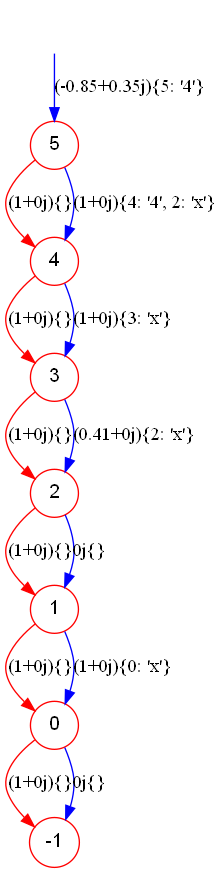

In [385]:
tdd_new2.show(False)

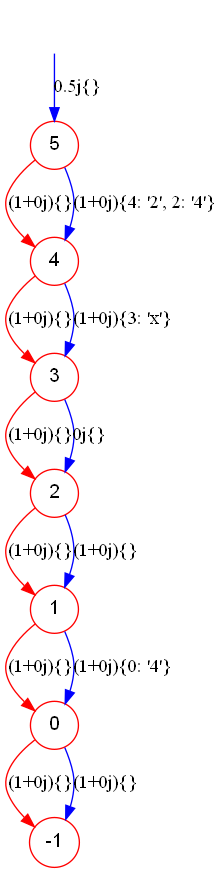

In [379]:
n=3
m=15

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True)

# tdd.show(False)
tdd_new,cir_head,cir_end=syn(tdd)
tdd_new.show(False)
# cir_end.draw()

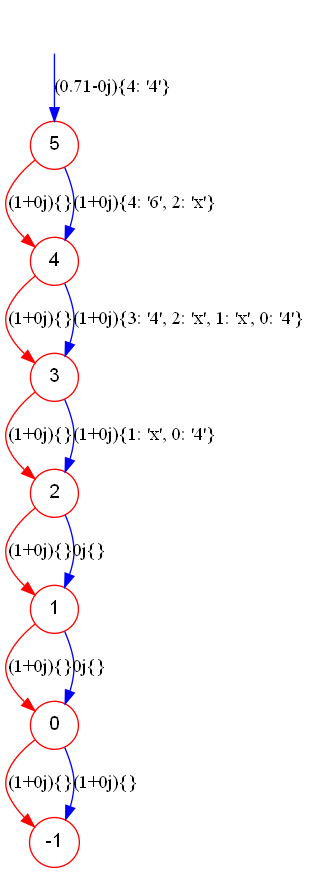

In [360]:
# cir.draw()
tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
# tdd_new,cir_head,cir_end=syn(tdd_new)
tdd_new.show(False)

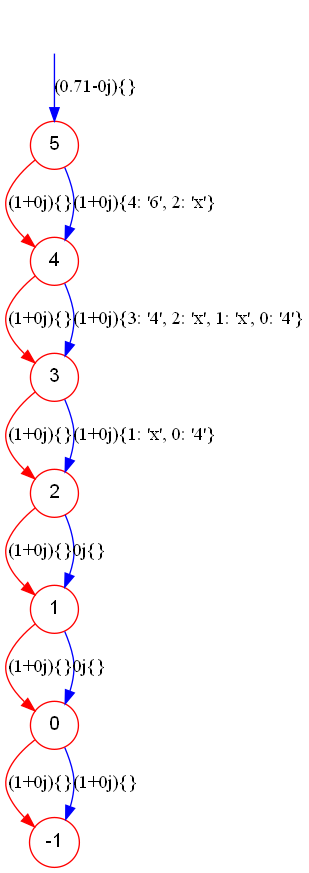

In [361]:
tdd_new2,cir_head2,cir_end2=eliminate_global_map2(tdd)
tdd_new2.show(False)

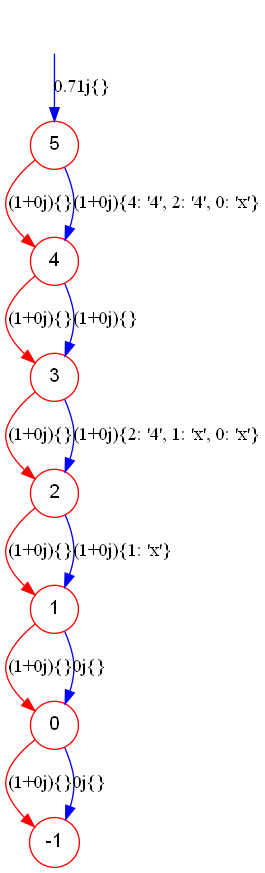

In [316]:
tdd_new2,cir_head,cir_end = reduce_hadamard2(tdd_new,n,0,1,2)
tdd_new2,cir_head,cir_end=syn(tdd_new2)
tdd_new2.show(False)

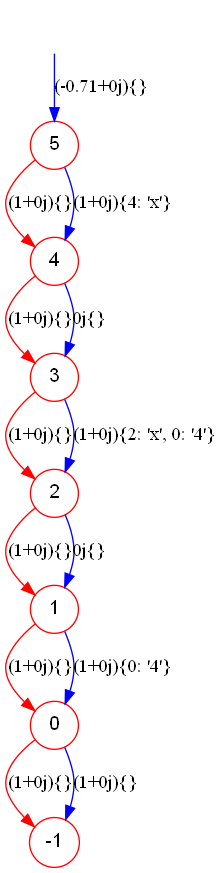

In [291]:
tdd_new3,cir_head,cir_end = reduce_hadamard2(tdd_new2,n,0,1,3)
tdd_new3,cir_head,cir_end=syn(tdd_new3)
tdd_new3.show(False)

In [102]:
# tdd_new4,cir_head,cir_end = reduce_hadamard2(tdd_new3,0,1,3)
# tdd_new4,cir_head,cir_end=syn(tdd_new4)
# tdd_new4.show(False)

In [386]:
# f=open('cannot be reduced by h2.qasm','w')
# f.write(cir.qasm())
# f.close()